In [7]:
# Check Python version
!python --version

# Install necessary libraries
!pip install torch torchvision catalyst albumentations pytorch-toolbelt timm iterative-stratification


Python 3.10.14


In [8]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import cv2
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from typing import List, Dict, Union

# Utility functions for image handling
def read_image_rgb(filepath: str) -> np.ndarray:
    """
    Reads an image in RGB format from the given file path.
    """
    image = cv2.imread(filepath, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"Image file not found: {filepath}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def read_mask(filepath: str) -> np.ndarray:
    """
    Reads a mask file.
    """
    from PIL import Image
    mask = np.array(Image.open(filepath))
    return mask

def overlay_damage_mask(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """
    Overlay a damage mask on an image for visualization.
    """
    overlay = image.copy()
    overlay[mask == 1] = (0, 255, 0)    # Green for undamaged
    overlay[mask == 2] = (255, 255, 0)  # Yellow for light damage
    overlay[mask == 3] = (255, 69, 0)   # Orange for medium damage
    overlay[mask == 4] = (255, 0, 0)    # Red for destroyed
    return cv2.addWeighted(overlay, 0.5, image, 0.5, 0)


In [9]:
# Import augmentation library
import albumentations as A

# Define augmentations
color_augmentations = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.RandomGamma(gamma_limit=(90, 110), p=0.5),
    A.Normalize()
])

spatial_augmentations = A.Compose([
    A.RandomSizedCrop((512 - 64, 512 + 64), 512, 512, p=1.0),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
])

# Define custom dataset class
class ImageMaskDataset(Dataset):
    def __init__(
        self,
        pre_image_filenames: List[str],
        post_image_filenames: List[str],
        post_mask_filenames: List[str],
        spatial_transform: A.Compose = None,
        color_transform: A.Compose = None
    ):
        self.pre_image_filenames = pre_image_filenames
        self.post_image_filenames = post_image_filenames
        self.post_mask_filenames = post_mask_filenames
        self.spatial_transform = spatial_transform
        self.color_transform = color_transform

    def __len__(self) -> int:
        return len(self.pre_image_filenames)

    def __getitem__(self, index: int) -> Dict[str, Union[torch.Tensor, np.ndarray]]:
        # Load images and masks
        pre_image = read_image_rgb(self.pre_image_filenames[index])
        post_image = read_image_rgb(self.post_image_filenames[index])
        mask = read_mask(self.post_mask_filenames[index])

        # Apply color augmentations
        if self.color_transform:
            pre_image = self.color_transform(image=pre_image)["image"]
            post_image = self.color_transform(image=post_image)["image"]

        # Combine images
        combined_image = np.dstack([pre_image, post_image])

        # Apply spatial augmentations
        if self.spatial_transform:
            transformed = self.spatial_transform(image=combined_image, mask=mask)
            combined_image = transformed["image"]
            mask = transformed["mask"]

        # Convert to tensors
        sample = {
            "image": torch.tensor(combined_image.transpose(2, 0, 1), dtype=torch.float32),
            "mask": torch.tensor(mask, dtype=torch.long)
        }
        return sample


In [12]:
import os
import numpy as np
import json
import cv2
from shapely.wkt import loads

# Define directories
image_dir = "/kaggle/input/xview2-challenge-dataset-tier-3-data/tier3/images"  # Replace with your image folder path
labels_dir = "/kaggle/input/xview2-challenge-dataset-tier-3-data/tier3/labels"  # Replace with your labels folder path
masks_dir = "/kaggle/working/masks"  # Replace with your desired masks folder path

os.makedirs(masks_dir, exist_ok=True)

# Utility function to create masks
def mask_for_polygon(poly, im_size=(1024, 1024)):
    img_mask = np.zeros(im_size, np.uint8)
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords)]
    interiors = [int_coords(pi.coords) for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

# Damage type dictionary
damage_dict = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    "un-classified": 1
}

# Process JSON files to create masks
def process_image(json_file):
    # Read pre- and post-disaster JSON files
    pre_json = json.load(open(json_file))
    post_json = json.load(open(json_file.replace('_pre_disaster', '_post_disaster')))

    # Initialize masks
    msk = np.zeros((1024, 1024), dtype='uint8')
    msk_damage = np.zeros((1024, 1024), dtype='uint8')

    # Create building mask
    for feat in pre_json['features']['xy']:
        poly = loads(feat['wkt'])
        _msk = mask_for_polygon(poly)
        msk[_msk > 0] = 255

    # Create damage mask
    for feat in post_json['features']['xy']:
        poly = loads(feat['wkt'])
        subtype = feat['properties']['subtype']
        _msk = mask_for_polygon(poly)
        msk_damage[_msk > 0] = damage_dict[subtype]

    # Save masks
    base_filename = os.path.basename(json_file).replace('_pre_disaster.json', '')
    pre_mask_path = os.path.join(masks_dir, f"{base_filename}_pre_disaster.png")
    post_mask_path = os.path.join(masks_dir, f"{base_filename}_post_disaster.png")
    cv2.imwrite(pre_mask_path, msk, [cv2.IMWRITE_PNG_COMPRESSION, 9])
    cv2.imwrite(post_mask_path, msk_damage, [cv2.IMWRITE_PNG_COMPRESSION, 9])

# Process all JSON files
json_files = [os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith('_pre_disaster.json')]
for json_file in json_files:
    process_image(json_file)

print("Masks created successfully.")


Masks created successfully.


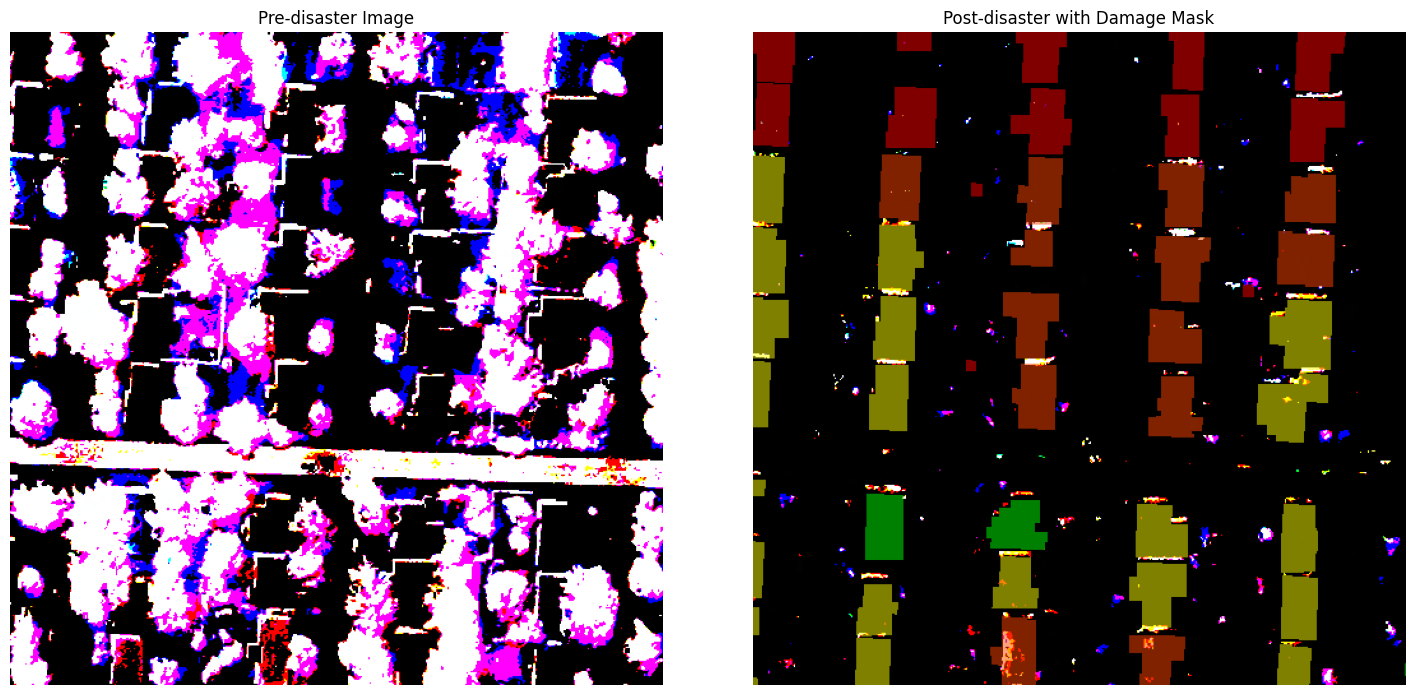

In [13]:
# Collect file paths for pre- and post-disaster images and masks
pre_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if '_pre_disaster.png' in f]
post_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if '_post_disaster.png' in f]
pre_masks = [os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if '_pre_disaster.png' in f]
post_masks = [os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if '_post_disaster.png' in f]

# Sort files to maintain consistent ordering
pre_images.sort()
post_images.sort()
pre_masks.sort()
post_masks.sort()

# Test dataset with a subset of data
test_dataset = ImageMaskDataset(
    pre_image_filenames=pre_images,
    post_image_filenames=post_images,
    post_mask_filenames=post_masks,
    spatial_transform=spatial_augmentations,
    color_transform=color_augmentations
)

# Visualize a sample from the dataset
import matplotlib.pyplot as plt

def visualize_sample(dataset, index):
    """
    Visualize a sample from the dataset.
    """
    sample = dataset[index]
    image = sample["image"].numpy().transpose(1, 2, 0)  # Convert to HWC format
    mask = sample["mask"].numpy()

    # Display the image and overlay mask
    f, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].imshow(image[:, :, :3].astype(np.uint8))  # Pre-disaster image
    ax[0].set_title("Pre-disaster Image")
    ax[0].axis("off")

    ax[1].imshow(overlay_damage_mask(image[:, :, 3:6].astype(np.uint8), mask))
    ax[1].set_title("Post-disaster with Damage Mask")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the first sample
visualize_sample(test_dataset, 0)


In [14]:
# Define the UNet Segmentation Model
class UnetSegmentationModel(nn.Module):
    def __init__(
        self,
        input_channels: int,
        num_classes: int,
        features: List[int] = [64, 128, 256, 512],
    ):
        super(UnetSegmentationModel, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.encoder.append(self._block(input_channels, feature))
            input_channels = feature

        # Decoder
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature * 2, feature))

        # Bottleneck
        self.bottleneck = self._block(features[-1], features[-1] * 2)

        # Final Convolution
        self.final_conv = nn.Conv2d(features[0], num_classes, kernel_size=1)

    def forward(self, x: Tensor) -> Tensor:
        skip_connections = []
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]
            x = torch.cat((x, skip_connection), dim=1)
            x = self.decoder[idx + 1](x)

        return self.final_conv(x)

    def _block(self, in_channels: int, out_channels: int, kernel_size: int = 3, padding: int = 1) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )


Input shape: torch.Size([1, 6, 512, 512])
Output shape: torch.Size([1, 5, 512, 512])


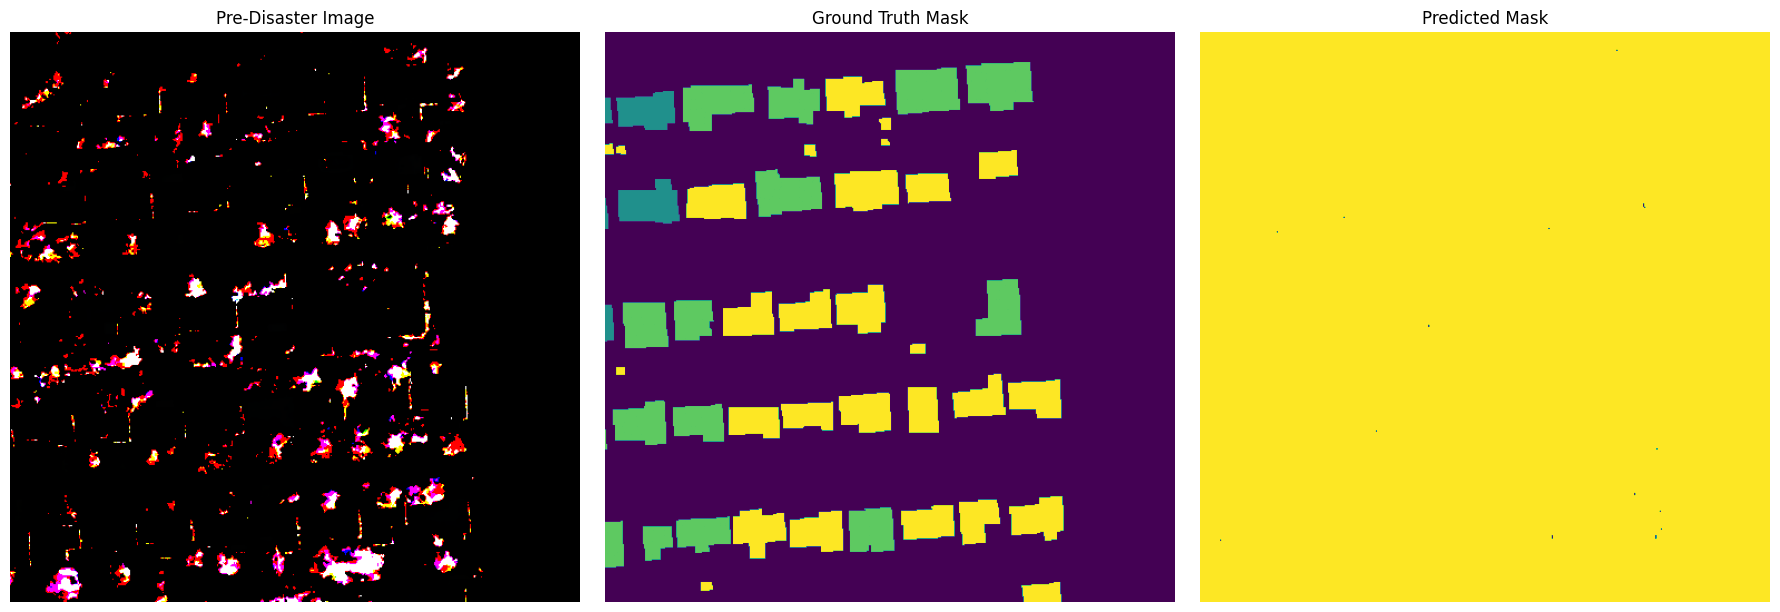

In [15]:
# Initialize the UNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UnetSegmentationModel(input_channels=6, num_classes=5).to(device)  # 6 input channels (pre + post), 5 damage classes

# Test the model with a sample batch
def test_model_on_sample(model, dataset):
    model.eval()  # Set model to evaluation mode
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)  # Single sample batch
    sample = next(iter(dataloader))  # Get the first sample

    image = sample["image"].to(device)  # Move image to the appropriate device
    mask = sample["mask"].to(device)   # Move mask to the appropriate device

    # Forward pass through the model
    with torch.no_grad():
        output = model(image)

    print(f"Input shape: {image.shape}")
    print(f"Output shape: {output.shape}")

    # Check the output predictions
    predicted_mask = torch.argmax(output, dim=1).cpu().numpy()  # Convert to numpy for visualization
    return image.cpu().numpy(), mask.cpu().numpy(), predicted_mask

# Test the model on the dataset
sample_image, sample_mask, predicted_mask = test_model_on_sample(model, test_dataset)

# Visualize the output
def visualize_model_output(image, mask, predicted_mask):
    f, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Pre-disaster image
    ax[0].imshow(image[0, :3].transpose(1, 2, 0).astype(np.uint8))  # Convert to HWC
    ax[0].set_title("Pre-Disaster Image")
    ax[0].axis("off")

    # Ground truth mask
    ax[1].imshow(mask[0], cmap="viridis")
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")

    # Predicted mask
    ax[2].imshow(predicted_mask[0], cmap="viridis")
    ax[2].set_title("Predicted Mask")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the result
visualize_model_output(sample_image, sample_mask, predicted_mask)


In [16]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training and validation loop
def train_model(model, train_dataset, val_dataset, epochs=5, batch_size=4):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device)
                masks = batch["mask"].to(device)

                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()

        # Log the losses
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"  Train Loss: {train_loss / len(train_loader):.4f}")
        print(f"  Val Loss: {val_loss / len(val_loader):.4f}")

# Split the dataset into training and validation subsets
train_size = int(0.8 * len(test_dataset))
val_size = len(test_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [train_size, val_size])

# Train the model
train_model(model, train_dataset, val_dataset, epochs=5, batch_size=4)


Epoch 1/5
  Train Loss: 0.4107
  Val Loss: 0.1315
Epoch 2/5
  Train Loss: 0.0959
  Val Loss: 0.0708
Epoch 3/5
  Train Loss: 0.0709
  Val Loss: 0.0576
Epoch 4/5
  Train Loss: 0.0599
  Val Loss: 0.0506
Epoch 5/5
  Train Loss: 0.0548
  Val Loss: 0.0458


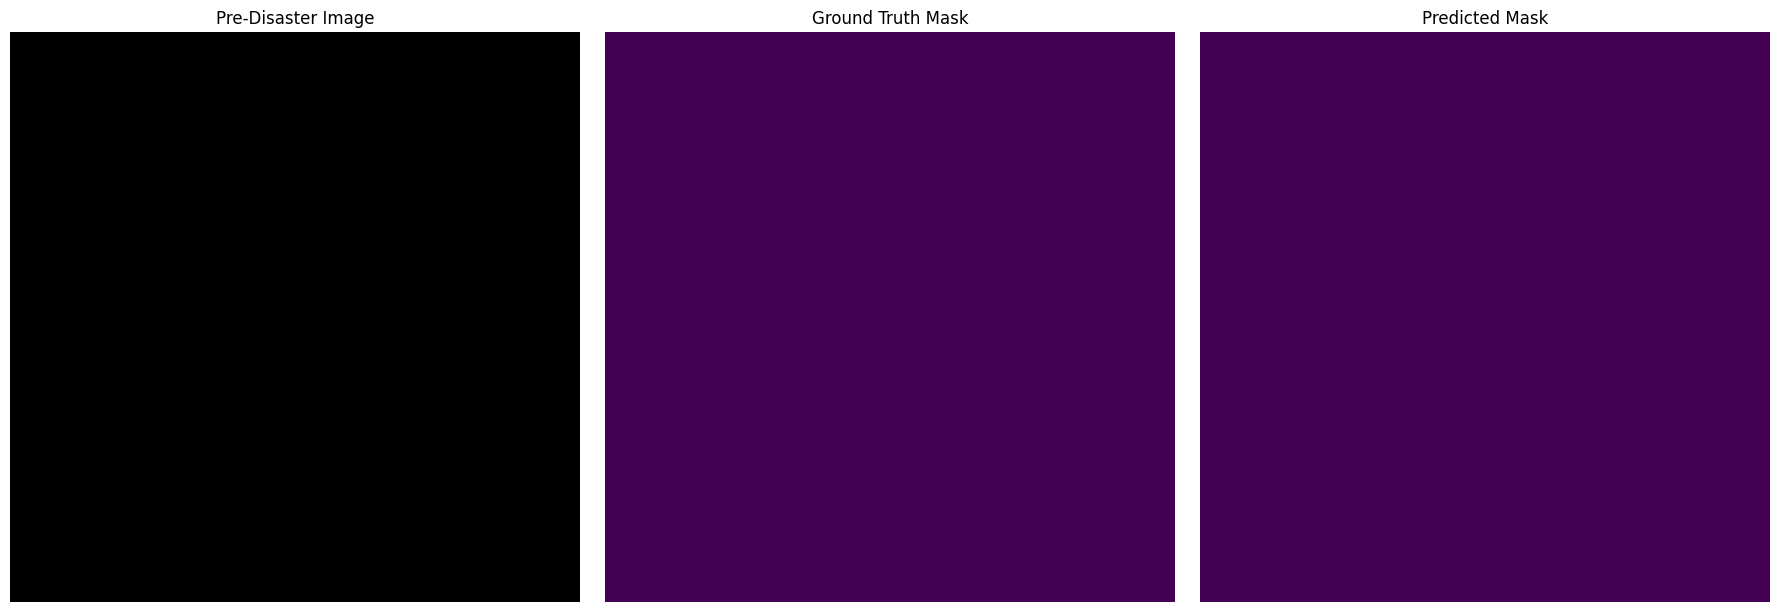

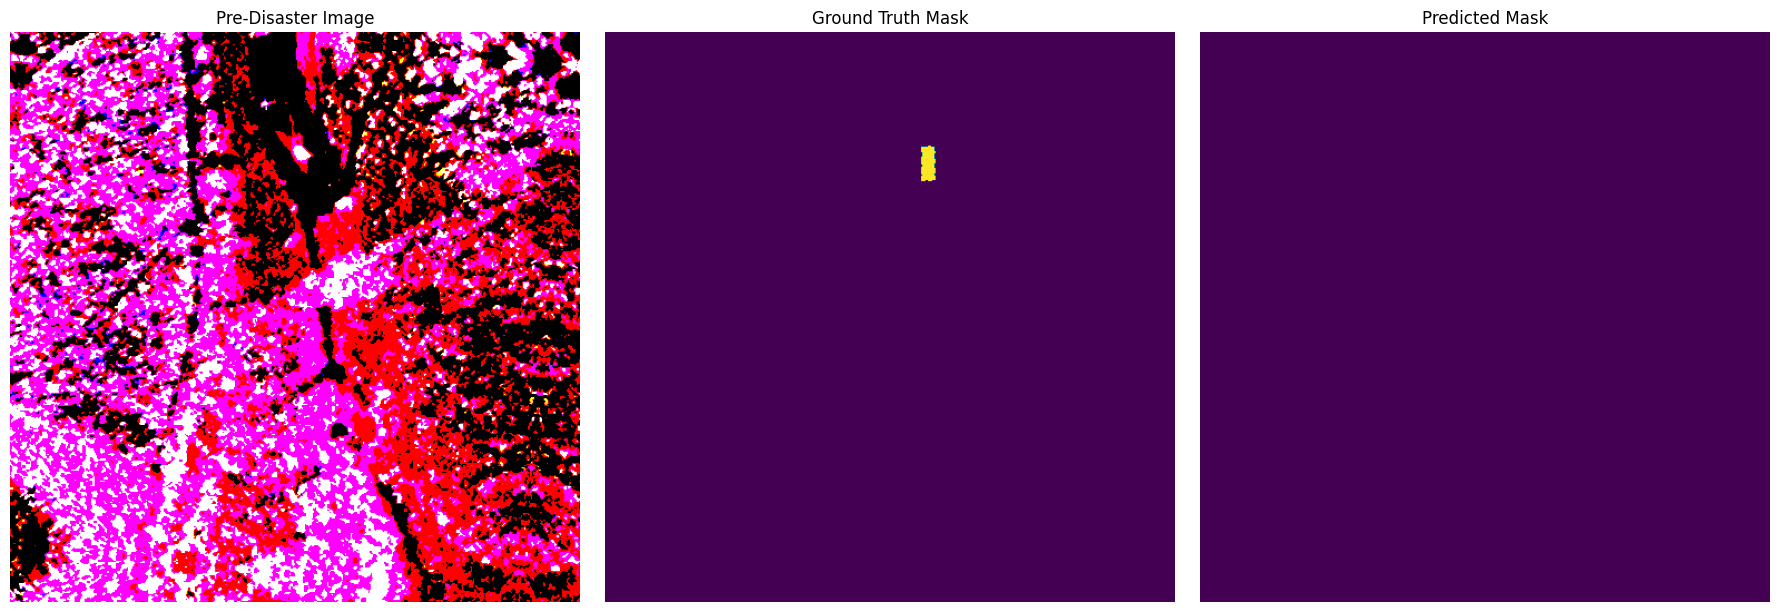

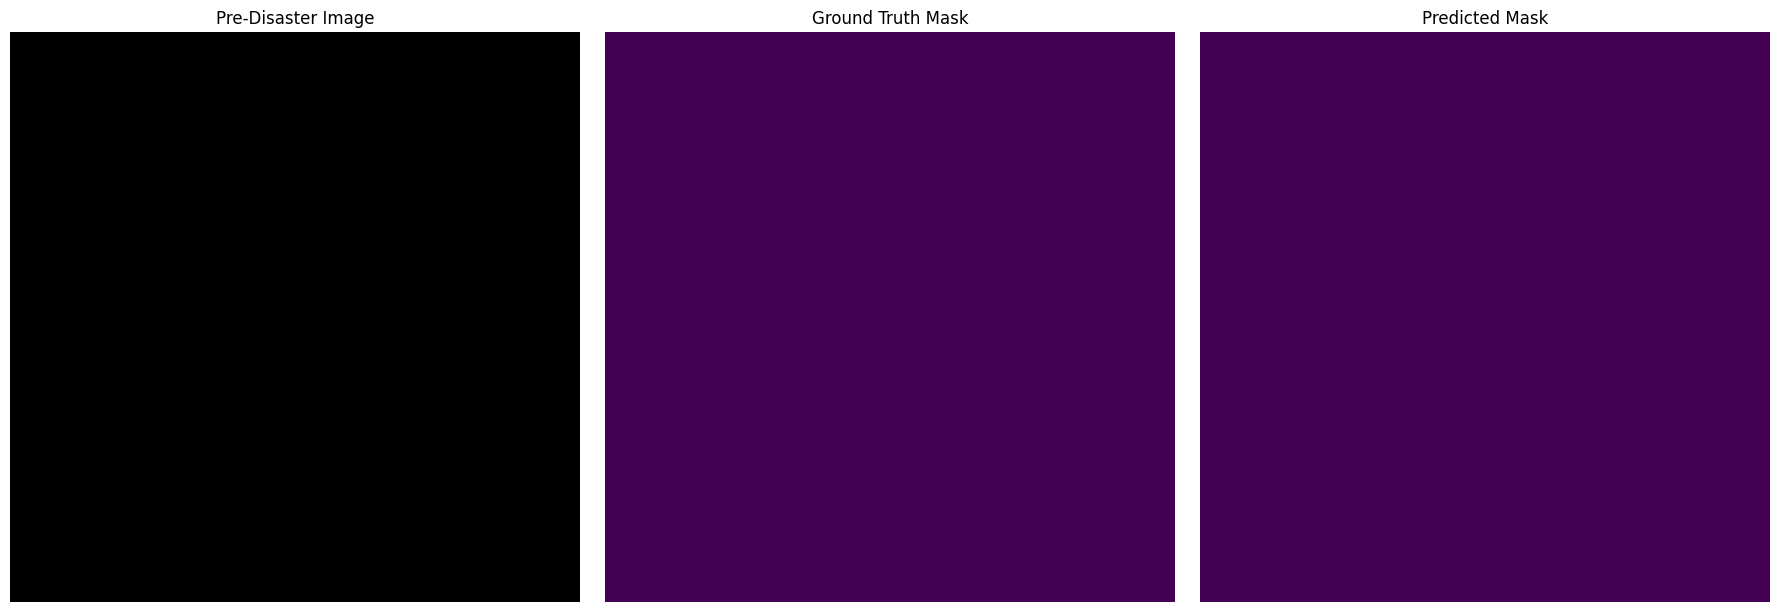

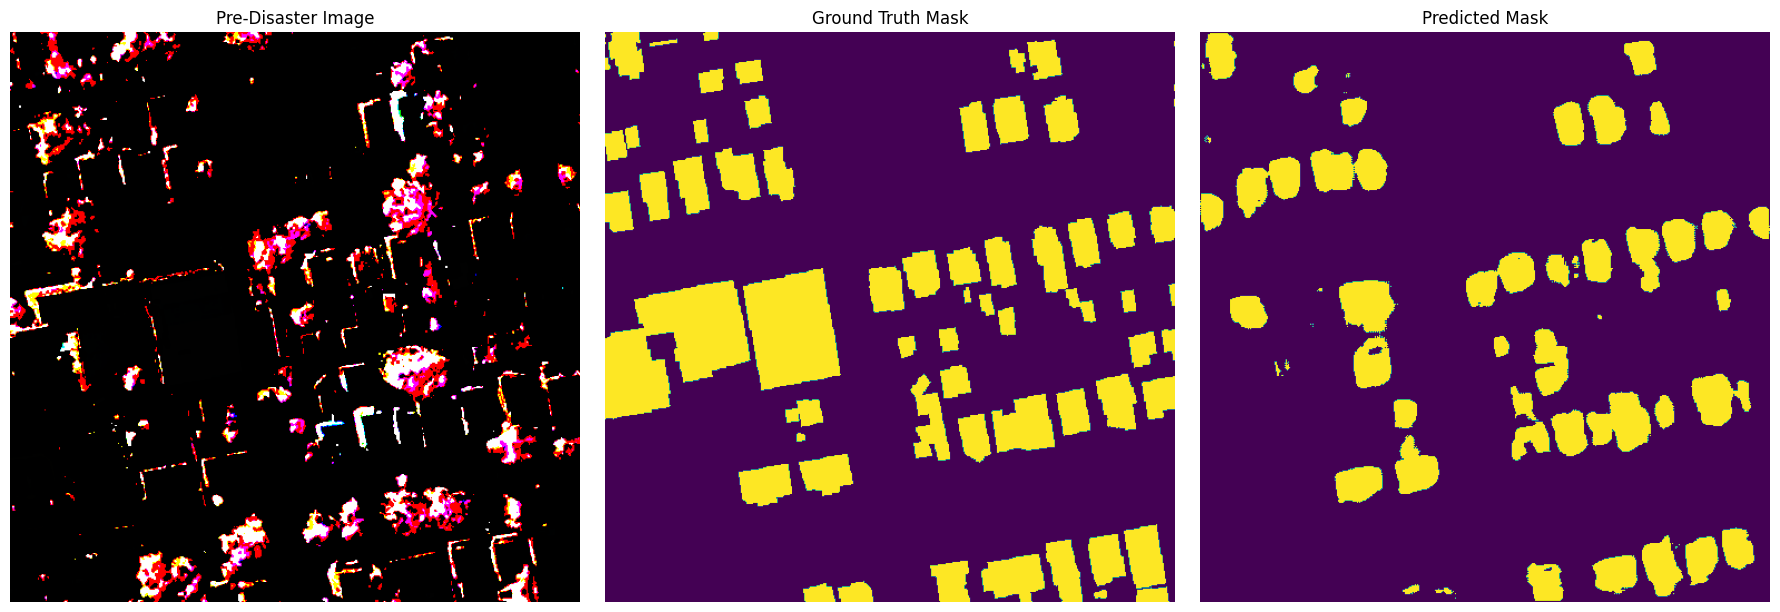

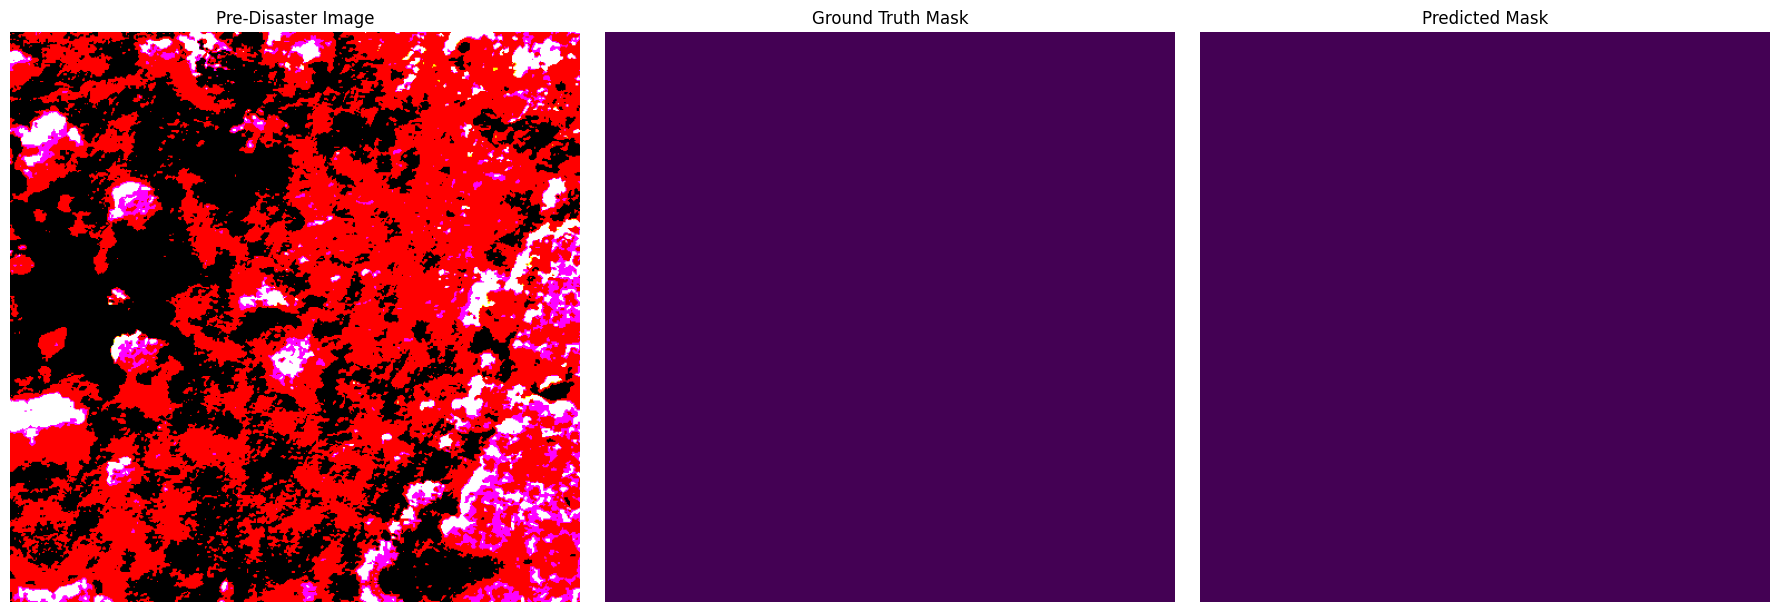

In [17]:
# Test the trained model on unseen data
def evaluate_model_on_holdout(model, dataset, num_samples=5):
    model.eval()  # Set model to evaluation mode
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

    for idx, batch in enumerate(dataloader):
        if idx >= num_samples:
            break  # Limit the number of samples displayed

        # Prepare inputs
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(images)

        # Process outputs
        predicted_masks = torch.argmax(outputs, dim=1).cpu().numpy()
        true_masks = masks.cpu().numpy()
        input_images = images.cpu().numpy()

        # Visualize
        visualize_model_output(input_images, true_masks, predicted_masks)

# Evaluate the model on holdout data (using validation dataset here as an example)
evaluate_model_on_holdout(model, val_dataset, num_samples=5)


In [18]:
# Save the trained model
model_save_path = "/kaggle/working/unet_damage_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Export predictions for validation dataset
def export_predictions(model, dataset, save_dir="/kaggle/working/predictions", num_samples=10):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    for idx, batch in enumerate(dataloader):
        if idx >= num_samples:
            break
        images = batch["image"].to(device)
        with torch.no_grad():
            outputs = model(images)
        predicted_mask = torch.argmax(outputs, dim=1).cpu().numpy()[0]

        # Save predicted mask
        save_path = os.path.join(save_dir, f"prediction_{idx}.png")
        cv2.imwrite(save_path, (predicted_mask * 50).astype(np.uint8))  # Scale for visualization
        print(f"Saved prediction {idx} to {save_path}")

# Export predictions
export_predictions(model, val_dataset, num_samples=5)


Model saved to /kaggle/working/unet_damage_model.pth
Saved prediction 0 to /kaggle/working/predictions/prediction_0.png
Saved prediction 1 to /kaggle/working/predictions/prediction_1.png
Saved prediction 2 to /kaggle/working/predictions/prediction_2.png
Saved prediction 3 to /kaggle/working/predictions/prediction_3.png
Saved prediction 4 to /kaggle/working/predictions/prediction_4.png


In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to calculate IoU for each class
def calculate_iou(y_true, y_pred, num_classes=5):
    iou_per_class = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        union = np.logical_or(y_true == cls, y_pred == cls).sum()
        if union == 0:
            iou_per_class.append(float('nan'))  # Ignore this class if it doesn't appear
        else:
            iou_per_class.append(intersection / union)
    return iou_per_class

# Function to calculate evaluation metrics
def evaluate_model(model, dataset, num_samples=10):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    all_true = []
    all_pred = []

    for idx, batch in enumerate(dataloader):
        if idx >= num_samples:
            break

        images = batch["image"].to(device)
        true_masks = batch["mask"].cpu().numpy()

        with torch.no_grad():
            outputs = model(images)
        predicted_masks = torch.argmax(outputs, dim=1).cpu().numpy()

        all_true.append(true_masks)
        all_pred.append(predicted_masks)

    # Flatten the arrays for metrics calculation
    all_true = np.concatenate([mask.flatten() for mask in all_true])
    all_pred = np.concatenate([mask.flatten() for mask in all_pred])

    # Pixel accuracy
    pixel_accuracy = (all_true == all_pred).mean()

    # IoU for each class
    iou_per_class = calculate_iou(all_true, all_pred)

    # F1 Score (per class)
    f1_per_class = []
    for cls in range(5):  # Assuming 5 damage classes
        cm = confusion_matrix(all_true, all_pred, labels=range(5))
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        if tp + fp + fn == 0:
            f1_per_class.append(float('nan'))
        else:
            f1 = 2 * tp / (2 * tp + fp + fn)
            f1_per_class.append(f1)

    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"IoU per Class: {iou_per_class}")
    print(f"F1 Score per Class: {f1_per_class}")

# Evaluate the model
evaluate_model(model, val_dataset, num_samples=10)


Pixel Accuracy: 0.9918
IoU per Class: [0.992338974357993, 0.29822680412371133, 0.0, 0.0, 0.0]
F1 Score per Class: [0.9961547579299472, 0.4594371386824217, 0.0, 0.0, 0.0]
